# 1D Triple Well Potential Langevin Dynamics

In [2]:
import sys
import os
import time

# Add the parent directory to the sys.path
LaRRR_path = os.path.abspath(os.path.join(os.getcwd(), '..','..'))
sys.path.append(LaRRR_path)

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Ensuring reproducibility
np.random.seed(14)

# state augmentation
from LaRRR.src.base import delay_embedding as augment

# report on predictions
from LaRRR.src.utils import report

In [2]:
from kooplearn.datasets import LangevinTripleWell1D

In [ ]:
def make_dataset(
    dt: float,
    verbose: bool = False,
    horizon: float = 200,
    rng_seed: int | None = None,
    dt0: float = 1e-4,
):
    burnin = 10
    num_steps = round(horizon / dt0)
    burin_steps = round(burnin / dt0)
    subsample = round(dt / dt0)
    if verbose:
        print(f"[INFO] num steps {num_steps}")
    langevin = LangevinTripleWell1D(rng_seed=rng_seed, gamma=2.0, dt=dt0)
    rng = np.random.default_rng(rng_seed)
    init_x = rng.uniform(-1, 1)
    traj = langevin.sample(init_x, num_steps+burin_steps, show_progress=verbose)
    return subsample * dt0, traj[burin_steps::subsample]

In [5]:
def custom_violin(ax, data, pos, fc='b', ec='k', alpha=0.7, percentiles=[25, 50, 75], side="both", scatter_kwargs={}, violin_kwargs={}):
    """Customized violin plot.
    ax: axes.Axes, The axes to plot to
    data: 1D array like, The data to plot
    pos: float, The position on the x-axis where the violin should be plotted
    fc: color, The facecolor of the violin
    ec: color, The edgecolor of the violin
    alpha: float, The transparancy of the violin
    percentiles: array like, The percentiles to be marked on the violin
    side: string, Which side(s) of the violin should be cut off. Options: 'left', 'right', 'both'
    scatter_kwargs: dict, Keyword arguments for the scatterplot
    violin_kwargs: dict, Keyword arguments for the violinplot"""

    parts = ax.violinplot(data, positions=[pos], **violin_kwargs)
    for pc in parts['bodies']:
        m = np.mean(pc.get_paths()[0].vertices[:, 0])
        if side == "left":
            points_x = pos - 0.05
            pc.get_paths()[0].vertices[:, 0] = np.clip(pc.get_paths()[0].vertices[:, 0], -np.inf, m)
        elif side == "right":
            points_x = pos + 0.05
            pc.get_paths()[0].vertices[:, 0] = np.clip(pc.get_paths()[0].vertices[:, 0], m, np.inf)
        else:
            points_x = pos
        pc.set_facecolor(fc)
        pc.set_edgecolor(ec)
        pc.set_alpha(alpha)

    perc = np.percentile(data, percentiles)
    for p in perc:
        ax.scatter(points_x, p, color=ec, zorder=3, **scatter_kwargs)

def add_label(violin, labels,label):
    color = violin["bodies"][0].get_facecolor().flatten()
    labels.append((mpatches.Patch(color=color), label))

In [ ]:
ref_eigs = np.load("/Users/vkiit/LaRRR/datasets/1d3w_langevin/ref_eigs.npy").real

## TO_RRR vs LA_RRR in dual form 

In [ ]:
from LaRRR.src.dual.reduced_rank import fit as dual_LaRRR
from LaRRR.src.dual.reduced_rank import fit_to as dual_ToRRR

from LaRRR.src.base import predict, modes

from sklearn.gaussian_process.kernels import RBF 

### Benchmark TO vs LIG

#### Compute the errors 

In [ ]:
#LaRRR_eigs = np.load(r"LaRRR_eigs-h=200-dt=5e-2.npy").real



H = 50

lscale = 0.5
kernel = RBF(length_scale=lscale)

shift = 0.05

context_length = 1

rank = 6
reg = 1e-6



LaRRR_time = 0
ToRRR_time = 0

dt_range = 0.5*(10**(-np.arange(9)/4)) #[0.005,0.01,0.05,0.1] #0.01, 0.005
num_repetitions = 10

LaRRR_eigs = np.zeros((len(dt_range),num_repetitions,rank))
ToRRR_eigs = np.zeros((len(dt_range),num_repetitions,rank))
LaRRR_err = np.zeros((len(dt_range),num_repetitions,rank-1))
ToRRR_err = np.zeros((len(dt_range),num_repetitions,rank-1))


for i in range(num_repetitions):
    dt0, sample_ = make_dataset(dt=0.0001, horizon=H, verbose=True, rng_seed=i)
    for dt_,dt in enumerate(dt_range):
        sample = sample_[::int(dt/dt0)]
        start_time = time.time()
        K = kernel(sample)
        end_time = time.time()
        ToRRR_time += (end_time - start_time)
        LaRRR_time += (end_time - start_time)
        start_time = time.time()
        ToRRR_eigs_ = dual_ToRRR(K=K,dt=dt,step=1,tikhonov_reg=reg,rank = rank,symmetry="symmetric")
        ToRRR_eigs[dt_,i]=ToRRR_eigs_["values"]
        ToRRR_err[dt_,i]=np.abs((ref_eigs[:rank]-ToRRR_eigs[dt_,i][::-1])/ref_eigs[:rank])[1:]
        end_time = time.time()
        print(f"ToRRR took {(end_time - start_time)}s to fit")
        ToRRR_time += (end_time - start_time)
        start_time = time.time()
        LaRRR_eigs_ = dual_LaRRR(K=K,dt=dt,shift=shift/dt,context_length=int(K.shape[0]*context_length),tikhonov_reg=reg,rank=rank,symmetric=True)
        LaRRR_eigs[dt_,i]=LaRRR_eigs_["values"]
        LaRRR_err[dt_,i]=np.abs((ref_eigs[:rank]-LaRRR_eigs[dt_,i][::-1])/ref_eigs[:rank])[1:]
        end_time = time.time()
        print(f"LaRRR took {(end_time - start_time)}s to fit")
        LaRRR_time += (end_time - start_time)
ToRRR_eigs = np.array(ToRRR_eigs)
LaRRR_eigs = np.array(LaRRR_eigs)
np.save("kooplearn_eigs", ToRRR_eigs)
np.save("LaRRR_eigs", LaRRR_eigs)
np.save("kooplearn_err", ToRRR_err)
np.save("LaRRR_err", LaRRR_err)


print("="*20)
print(f" Time steps dt={dt_range}")
print("="*20)
print(f" Total times TO {ToRRR_time}sec and IG time {LaRRR_time}sec")
print(f" Mean +/- STD for LaRRR is {np.mean(LaRRR_err, axis=1)} +/- {np.std(LaRRR_err, axis=1)}")
print(f" Mean +/- STD for TORRR is {np.mean(ToRRR_err, axis=1)} +/- {np.std(ToRRR_err, axis=1)}")

[INFO] num steps 500000


Generating data:   0%|          | 0/600000 [00:00<?, ?step/s]

/Users/vkiit/Glearn/Glearn/src/dual/reduced_rank.py:327: RuntimeWarning: invalid value encountered in log
  values = np.log(values)/(step*dt)
/var/folders/vw/tpml6nwn6yb0prw0bm4v91wm0000gn/T/ipykernel_37045/3301885471.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  LaRRR_eigs[dt_,i]=LaRRR_eigs_["values"]


ToRRR took 0.0531468391418457s to fit
LaRRR took 0.047434091567993164s to fit
ToRRR took 0.02174687385559082s to fit
LaRRR took 0.05131697654724121s to fit
ToRRR took 0.021071910858154297s to fit


LaRRR took 0.22331500053405762s to fit
ToRRR took 0.057517051696777344s to fit
LaRRR took 0.23070120811462402s to fit
ToRRR took 0.36971306800842285s to fit


LaRRR took 0.4613478183746338s to fit
ToRRR took 5.63704776763916s to fit


LaRRR took 1.7409038543701172s to fit
ToRRR took 10.100556135177612s to fit


LaRRR took 8.008002042770386s to fit
ToRRR took 14.085033893585205s to fit


LaRRR took 11.75037693977356s to fit
ToRRR took 48.244558811187744s to fit


LaRRR took 52.51776313781738s to fit
[INFO] num steps 500000


ToRRR took 0.019451141357421875s to fit
LaRRR took 0.026181936264038086s to fit
ToRRR took 0.013679742813110352s to fit
LaRRR took 0.029249191284179688s to fit
ToRRR took 0.032113075256347656s to fit
LaRRR took 0.03983116149902344s to fit
ToRRR took 0.058107852935791016s to fit
LaRRR took 0.08332324028015137s to fit
ToRRR took 0.3011739253997803s to fit


LaRRR took 0.39272069931030273s to fit
ToRRR took 1.2392091751098633s to fit


LaRRR took 0.9829778671264648s to fit
ToRRR took 36.27868628501892s to fit


LaRRR took 3.1222898960113525s to fit
ToRRR took 13.378473043441772s to fit


LaRRR took 23.850687980651855s to fit
ToRRR took 50.94277286529541s to fit


LaRRR took 66.34400725364685s to fit
[INFO] num steps 500000


ToRRR took 0.016885042190551758s to fit
LaRRR took 0.01634812355041504s to fit
ToRRR took 0.011503219604492188s to fit
LaRRR took 0.021836042404174805s to fit
ToRRR took 0.01970696449279785s to fit
LaRRR took 0.022696971893310547s to fit
ToRRR took 0.0488278865814209s to fit


LaRRR took 0.07253718376159668s to fit
ToRRR took 0.19152116775512695s to fit


LaRRR took 0.35243988037109375s to fit
ToRRR took 0.954118013381958s to fit


LaRRR took 1.4030687808990479s to fit
ToRRR took 5.380431175231934s to fit


LaRRR took 4.179454803466797s to fit
ToRRR took 16.116759777069092s to fit


LaRRR took 15.009957790374756s to fit
ToRRR took 74.33742380142212s to fit


LaRRR took 84.73963594436646s to fit
[INFO] num steps 500000


ToRRR took 0.02436518669128418s to fit
LaRRR took 0.03513693809509277s to fit
ToRRR took 0.018524885177612305s to fit
LaRRR took 0.02062392234802246s to fit
ToRRR took 0.026661157608032227s to fit
LaRRR took 0.028944015502929688s to fit
ToRRR took 0.06917214393615723s to fit
LaRRR took 0.11049485206604004s to fit
ToRRR took 0.6556060314178467s to fit


LaRRR took 0.4229152202606201s to fit
ToRRR took 0.8896350860595703s to fit


LaRRR took 2.481545925140381s to fit
ToRRR took 10.40361499786377s to fit


LaRRR took 9.710853099822998s to fit
ToRRR took 32.82060480117798s to fit


LaRRR took 41.570656061172485s to fit
ToRRR took 64.40159678459167s to fit


LaRRR took 103.50178694725037s to fit
[INFO] num steps 500000


ToRRR took 0.021551132202148438s to fit
LaRRR took 0.012817859649658203s to fit
ToRRR took 0.009392261505126953s to fit
LaRRR took 0.015606164932250977s to fit
ToRRR took 0.020611047744750977s to fit
LaRRR took 0.02271103858947754s to fit
ToRRR took 0.056380271911621094s to fit
LaRRR took 0.053093910217285156s to fit


ToRRR took 0.19109010696411133s to fit
LaRRR took 0.1861109733581543s to fit
ToRRR took 0.6536362171173096s to fit


LaRRR took 1.0923449993133545s to fit
ToRRR took 24.490615129470825s to fit


LaRRR took 4.173160076141357s to fit
ToRRR took 12.668910026550293s to fit


LaRRR took 14.12036681175232s to fit
ToRRR took 64.49165797233582s to fit


LaRRR took 78.4714469909668s to fit
[INFO] num steps 500000


ToRRR took 0.02661299705505371s to fit
LaRRR took 0.055582284927368164s to fit
ToRRR took 0.020436763763427734s to fit
LaRRR took 0.030518054962158203s to fit
ToRRR took 0.03674602508544922s to fit
LaRRR took 0.0434260368347168s to fit
ToRRR took 0.06699371337890625s to fit
LaRRR took 0.0896446704864502s to fit
ToRRR took 0.274716854095459s to fit
LaRRR took 0.5249800682067871s to fit
ToRRR took 7.935074806213379s to fit


LaRRR took 1.4707109928131104s to fit
ToRRR took 4.2206690311431885s to fit


LaRRR took 4.269972801208496s to fit
ToRRR took 14.497660160064697s to fit


LaRRR took 21.380106925964355s to fit
ToRRR took 77.4017722606659s to fit


LaRRR took 72.12398386001587s to fit
[INFO] num steps 500000


ToRRR took 0.033785104751586914s to fit
LaRRR took 0.040509939193725586s to fit
ToRRR took 0.03061985969543457s to fit
LaRRR took 0.02509593963623047s to fit
ToRRR took 0.026015043258666992s to fit
LaRRR took 0.03949904441833496s to fit


ToRRR took 0.05851411819458008s to fit
LaRRR took 0.13758516311645508s to fit
ToRRR took 0.17969989776611328s to fit


LaRRR took 0.44484996795654297s to fit
ToRRR took 6.038697957992554s to fit


LaRRR took 0.8904039859771729s to fit
ToRRR took 14.181639194488525s to fit


LaRRR took 6.204292058944702s to fit
ToRRR took 15.182426691055298s to fit


LaRRR took 17.38282585144043s to fit
ToRRR took 66.26817798614502s to fit


LaRRR took 77.73034286499023s to fit
[INFO] num steps 500000


ToRRR took 0.012786865234375s to fit
LaRRR took 0.017580032348632812s to fit
ToRRR took 0.028364896774291992s to fit
LaRRR took 0.016108989715576172s to fit
ToRRR took 0.022831201553344727s to fit
LaRRR took 0.021188735961914062s to fit
ToRRR took 0.12556791305541992s to fit
LaRRR took 0.1805100440979004s to fit


ToRRR took 0.3793628215789795s to fit
LaRRR took 0.18817496299743652s to fit
ToRRR took 1.2477779388427734s to fit


LaRRR took 1.3528282642364502s to fit
ToRRR took 17.192018032073975s to fit


LaRRR took 3.662466049194336s to fit
ToRRR took 17.577916860580444s to fit


LaRRR took 17.667643785476685s to fit
ToRRR took 69.97287893295288s to fit


LaRRR took 90.39075803756714s to fit
[INFO] num steps 500000


ToRRR took 0.016934871673583984s to fit
LaRRR took 0.02875804901123047s to fit
ToRRR took 0.017466306686401367s to fit
LaRRR took 0.03938913345336914s to fit
ToRRR took 0.02551722526550293s to fit
LaRRR took 0.03299212455749512s to fit
ToRRR took 0.07297277450561523s to fit


LaRRR took 0.21184992790222168s to fit
ToRRR took 0.26058125495910645s to fit


LaRRR took 0.40047693252563477s to fit
ToRRR took 5.683928728103638s to fit


LaRRR took 1.2422308921813965s to fit
ToRRR took 8.256284952163696s to fit


LaRRR took 7.392638206481934s to fit
ToRRR took 13.998234033584595s to fit


LaRRR took 15.095104217529297s to fit
ToRRR took 56.887269258499146s to fit


LaRRR took 58.02407097816467s to fit
[INFO] num steps 500000


ToRRR took 0.018908977508544922s to fit
LaRRR took 0.026185989379882812s to fit
ToRRR took 0.015372037887573242s to fit
LaRRR took 0.03435707092285156s to fit
ToRRR took 0.021746158599853516s to fit
LaRRR took 0.02716970443725586s to fit
ToRRR took 0.04906320571899414s to fit
LaRRR took 0.07109189033508301s to fit
ToRRR took 0.27324891090393066s to fit


LaRRR took 0.523176908493042s to fit
ToRRR took 2.085369110107422s to fit


LaRRR took 1.8573329448699951s to fit
ToRRR took 10.812920093536377s to fit


LaRRR took 2.830029010772705s to fit
ToRRR took 14.550225019454956s to fit


LaRRR took 15.590181112289429s to fit
ToRRR took 59.69578719139099s to fit


LaRRR took 72.29500007629395s to fit
 Time steps dt=[0.5        0.28117066 0.15811388 0.08891397 0.05       0.02811707
 0.01581139 0.0088914  0.005     ]
 Total times TO 1011.8204712867737sec and IG time 1060.0486617088318sec
 Mean +/- STD for LaRRR is [[0.50918643 0.22891827 0.21790482 0.70977221 0.58586774]
 [0.52453328 0.21441114 0.22617028 0.71473365 0.58123039]
 [0.41271977 0.35173303 0.25681329 0.67538761 0.51163162]
 [0.34743501 0.47635171 0.25843624 0.51489414 0.38381697]
 [0.33766566 0.39080986 0.19492661 0.21840228 0.17659709]
 [0.29923494 0.28173251 0.1184983  0.12485664 0.16303839]
 [0.26334017 0.22508652 0.08495491 0.08295815 0.1566929 ]
 [0.24175559 0.17119894 0.07036247 0.05894436 0.14429563]
 [0.28242191 0.1423431  0.08103037 0.06207531 0.13207259]] +/- [[0.5140678  0.13813799 0.14158342 0.06613634 0.10005346]
 [0.80259316 0.17451006 0.18144547 0.10234651 0.12285778]
 [0.48046689 0.362746   0.11614723 0.07598989 0.13022945]
 [0.34611725 0.43434049 0.19556621 0.14959442 

#### Analyize the errors

In [5]:
LaRRR_err = np.load("/Users/vkiit/LaRRR/examples/LaRRR_err.npy").real
ToRRR_err = np.load("/Users/vkiit/LaRRR/examples/kooplearn_err.npy").real

# Compute statistics of errors
LaRRR_err_median = np.median(LaRRR_err, axis=1)
LaRRR_err_quantile_lower = np.quantile(LaRRR_err, q =0.25, axis=1)
LaRRR_err_quantile_upper= np.quantile(LaRRR_err, q =0.75, axis=1)
ToRRR_err_median = np.median(ToRRR_err, axis=1)
ToRRR_err_quantile_lower = np.quantile(ToRRR_err, q =0.25, axis=1)
ToRRR_err_quantile_upper= np.quantile(ToRRR_err, q =0.75, axis=1)

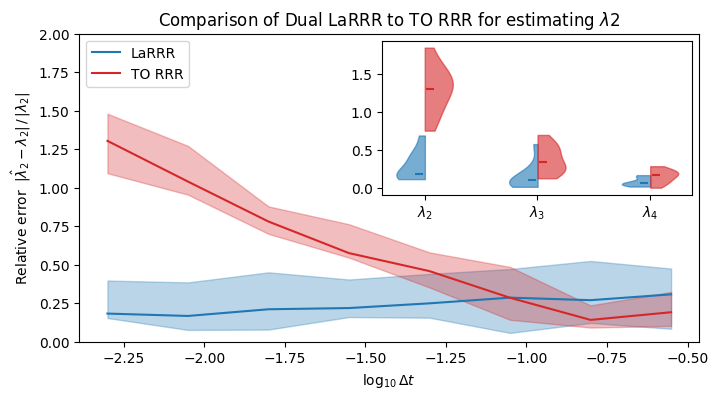

In [7]:
# Plotting
eval_idx = 0
dt_index = -1
dt_range = np.log10(0.5*(10**(-np.arange(9)/4))) #[0.005,0.01,0.05,0.1] #0.01, 0.005
 
plt.figure(figsize=(8, 4))

# Plot LaRRR with shading
plt.plot(dt_range[1:], LaRRR_err_median[1:,eval_idx], label='LaRRR', color='tab:blue')
plt.fill_between(dt_range[1:], LaRRR_err_quantile_lower[1:,eval_idx], LaRRR_err_quantile_upper[1:,eval_idx], color='tab:blue', alpha=0.3)

# Plot LaRRR with shading
plt.plot(dt_range[1:], ToRRR_err_median[1:,eval_idx], label='TO RRR', color='tab:red')
plt.fill_between(dt_range[1:], ToRRR_err_quantile_lower[1:,eval_idx], ToRRR_err_quantile_upper[1:,eval_idx], color='tab:red', alpha=0.3)

# Add labels, title, and legend
#plt.xticks(ticks = dt_range, labels=[".005",".01", ".05", ".1" ][::-1])
#plt.xlim([0,0.1])
plt.xlabel('$\log_{10} \Delta t$')
plt.ylim([0,2])
plt.ylabel('Relative error $\;|\hat{\lambda}_2 - \lambda_2| \,/\,|\lambda_2|$')
plt.title('Comparison of Dual LaRRR to TO RRR for estimating $\lambda'+str(eval_idx+2)+'$')
plt.legend(loc="upper left")

# Create inset axes for the violin plot
ax_inset = inset_axes(plt.gca(), width="50%", height="50%", loc='upper right')

# Style of violin plots
s_kwargs = {"s": 40, "marker": "_"}
v_kwargs = {"showextrema": False, "showmedians": False, "showmeans": False, "widths": 0.5}
labels = [r'$\lambda_2$', r'$\lambda_3$', r'$\lambda_4$']

for i in range(3):
    # Create violin plot for array 'IG'
    custom_violin(ax_inset, LaRRR_err[dt_index,:, i], i  , 'tab:blue', 'tab:blue', 0.6, percentiles=[50], side="left", scatter_kwargs=s_kwargs, violin_kwargs=v_kwargs)
    
    # Create violin plot for array 'TO'
    custom_violin(ax_inset, ToRRR_err[dt_index,:, i], i , 'tab:red', 'tab:red', 0.6, percentiles=[50], side = "right", scatter_kwargs=s_kwargs, violin_kwargs=v_kwargs)

#plt.legend(labels=["IG distribution","IG meadian","TO  distribution","TO meadian"])

ax_inset.set_xticks([i for i in range(3)])
ax_inset.set_xticklabels(labels)


# Show the plot
plt.show()

## TO RRR vs LaRRR in primal form

In [ ]:
from LaRRR.src.base import OrthogonalRandomFeatures

from LaRRR.src.primal.reduced_rank import fit as dual_LaRRR
from LaRRR.src.primal.reduced_rank import fit_to as dual_ToRRR

import torch

In [8]:
lscale = 0.5
num_random_features = 2048

In [9]:
orf = OrthogonalRandomFeatures(input_dim=1, num_random_features = num_random_features,
        length_scale = lscale, rng_seed = None)


def feature_map(X):
    features_pt = orf(torch.from_numpy(X))
    return features_pt.numpy(force=True)

### Benchmarking

In [ ]:
#LaRRR_eigs = np.load(r"LaRRR_eigs-h=200-dt=5e-2.npy").real

H = 50

lscale = 0.5

shift = 0.05

context_length = 1

rank = 6
reg = 1e-6



LaRRR_time = 0
ToRRR_time = 0

dt_range = 0.5*(10**(-np.arange(9)/4)) #[0.005,0.01,0.05,0.1] #0.01, 0.005
num_repetitions = 10

LaRRR_eigs = np.zeros((len(dt_range),num_repetitions,rank))
ToRRR_eigs = np.zeros((len(dt_range),num_repetitions,rank))
LaRRR_err = np.zeros((len(dt_range),num_repetitions,rank-1))
ToRRR_err = np.zeros((len(dt_range),num_repetitions,rank-1))


for i in range(num_repetitions):
    dt0, sample_ = make_dataset(dt=0.0001, horizon=H, verbose=True, rng_seed=i)
    for dt_,dt in enumerate(dt_range):
        sample = sample_[::int(dt/dt0)]
        Z=feature_map(sample)
        start_time = time.time()
        end_time = time.time()
        ToRRR_time += (end_time - start_time)
        LaRRR_time += (end_time - start_time)
        start_time = time.time()
        ToRRR_eigs_ = dual_ToRRR(Z=Z,dt=dt,tikhonov_reg=reg,rank = rank,symmetry="symmetric")
        ToRRR_eigs[dt_,i]=ToRRR_eigs_["values"]
        ToRRR_err[dt_,i]=np.abs((ref_eigs[:rank]-ToRRR_eigs[dt_,i][::-1])/ref_eigs[:rank])[1:]
        end_time = time.time()
        print(f"ToRRR took {(end_time - start_time)}s to fit")
        ToRRR_time += (end_time - start_time)
        start_time = time.time()
        LaRRR_eigs_ = dual_LaRRR(Z=Z,dt=dt,shift=shift/dt,context_length=int(sample.shape[0]*context_length),tikhonov_reg=reg,rank=rank,symmetric=True)
        LaRRR_eigs[dt_,i]=LaRRR_eigs_["values"]
        LaRRR_err[dt_,i]=np.abs((ref_eigs[1:rank]-LaRRR_eigs[dt_,i][::-1][:rank-1])/ref_eigs[1:rank])
        end_time = time.time()
        print(f"LaRRR took {(end_time - start_time)}s to fit")
        LaRRR_time += (end_time - start_time)
ToRRR_eigs = np.array(ToRRR_eigs)
LaRRR_eigs = np.array(LaRRR_eigs)
np.save("primal_kooplearn_eigs", ToRRR_eigs)
np.save("primal_LaRRR_eigs", LaRRR_eigs)
np.save("primal_kooplearn_err", ToRRR_err)
np.save("primal_LaRRR_err", LaRRR_err)


print("="*20)
print(f" Time steps dt={dt_range}")
print("="*20)
print(f" Total times TO {ToRRR_time}sec and IG time {LaRRR_time}sec")
print(f" Mean +/- STD for LaRRR is {np.mean(LaRRR_err, axis=1)} +/- {np.std(LaRRR_err, axis=1)}")
print(f" Mean +/- STD for TORRR is {np.mean(ToRRR_err, axis=1)} +/- {np.std(ToRRR_err, axis=1)}")

[INFO] num steps 500000


/Users/vkiit/Glearn/Glearn/src/primal/reduced_rank.py:220: RuntimeWarning: invalid value encountered in log
  values = np.log(values)/dt


ToRRR took 0.6839282512664795s to fit
LaRRR took 1.3690869808197021s to fit
ToRRR took 0.742995023727417s to fit
LaRRR took 1.5079638957977295s to fit
ToRRR took 1.3564660549163818s to fit
LaRRR took 1.4682950973510742s to fit


ToRRR took 1.0208637714385986s to fit
LaRRR took 0.9756827354431152s to fit
ToRRR took 0.9473450183868408s to fit
LaRRR took 0.950814962387085s to fit
ToRRR took 0.7385268211364746s to fit
LaRRR took 1.0266640186309814s to fit
ToRRR took 0.8035662174224854s to fit
LaRRR took 1.3508141040802002s to fit
ToRRR took 0.8699977397918701s to fit
LaRRR took 2.498328685760498s to fit
ToRRR took 2.075301170349121s to fit
LaRRR took 6.754931926727295s to fit
[INFO] num steps 500000


ToRRR took 0.5283830165863037s to fit
LaRRR took 1.2067198753356934s to fit
ToRRR took 1.104308843612671s to fit
LaRRR took 1.17917799949646s to fit
ToRRR took 0.6724309921264648s to fit
LaRRR took 1.1058077812194824s to fit
ToRRR took 0.6033017635345459s to fit
LaRRR took 1.0537710189819336s to fit
ToRRR took 0.8339300155639648s to fit
LaRRR took 1.0115978717803955s to fit
ToRRR took 0.782031774520874s to fit
LaRRR took 1.077355146408081s to fit
ToRRR took 1.0016980171203613s to fit
LaRRR took 1.7378389835357666s to fit
ToRRR took 1.063471794128418s to fit
LaRRR took 2.916285991668701s to fit
ToRRR took 1.499021053314209s to fit
LaRRR took 6.727807998657227s to fit
[INFO] num steps 500000


ToRRR took 0.7648639678955078s to fit
LaRRR took 1.136897087097168s to fit
ToRRR took 1.1761150360107422s to fit
LaRRR took 1.4602601528167725s to fit
ToRRR took 0.7916128635406494s to fit
LaRRR took 1.1947572231292725s to fit
ToRRR took 0.9040420055389404s to fit
LaRRR took 1.2070720195770264s to fit
ToRRR took 0.5828132629394531s to fit
LaRRR took 1.1377499103546143s to fit
ToRRR took 0.7963979244232178s to fit
LaRRR took 1.276885986328125s to fit
ToRRR took 1.2212738990783691s to fit
LaRRR took 1.6730239391326904s to fit
ToRRR took 1.1425139904022217s to fit
LaRRR took 2.939128875732422s to fit
ToRRR took 1.5539488792419434s to fit
LaRRR took 7.513033866882324s to fit
[INFO] num steps 500000


ToRRR took 0.998802900314331s to fit
LaRRR took 1.1982440948486328s to fit
ToRRR took 0.9982128143310547s to fit
LaRRR took 1.2925832271575928s to fit
ToRRR took 1.079258918762207s to fit
LaRRR took 1.4313569068908691s to fit
ToRRR took 0.9798488616943359s to fit
LaRRR took 1.2074790000915527s to fit
ToRRR took 1.1133708953857422s to fit
LaRRR took 1.1146907806396484s to fit
ToRRR took 1.4901800155639648s to fit
LaRRR took 1.1093261241912842s to fit
ToRRR took 0.9262039661407471s to fit
LaRRR took 1.6450631618499756s to fit
ToRRR took 1.454977035522461s to fit
LaRRR took 2.529810905456543s to fit
ToRRR took 1.3652992248535156s to fit
LaRRR took 6.326902866363525s to fit
[INFO] num steps 500000


ToRRR took 0.6105761528015137s to fit
LaRRR took 1.6782069206237793s to fit
ToRRR took 1.0874040126800537s to fit
LaRRR took 1.1663730144500732s to fit
ToRRR took 1.3542468547821045s to fit
LaRRR took 1.174009084701538s to fit
ToRRR took 0.7882668972015381s to fit
LaRRR took 1.285228967666626s to fit
ToRRR took 0.7704911231994629s to fit
LaRRR took 1.2381160259246826s to fit
ToRRR took 0.9491391181945801s to fit
LaRRR took 1.431609869003296s to fit
ToRRR took 1.1570298671722412s to fit
LaRRR took 2.0208652019500732s to fit
ToRRR took 1.571099042892456s to fit
LaRRR took 2.7667510509490967s to fit
ToRRR took 1.476027250289917s to fit
LaRRR took 6.684305906295776s to fit
[INFO] num steps 500000


ToRRR took 0.6942100524902344s to fit
LaRRR took 1.0004551410675049s to fit
ToRRR took 0.8115427494049072s to fit
LaRRR took 1.235584020614624s to fit
ToRRR took 0.6064050197601318s to fit
LaRRR took 1.1541402339935303s to fit
ToRRR took 1.21488618850708s to fit
LaRRR took 1.178581953048706s to fit
ToRRR took 0.9986553192138672s to fit
LaRRR took 1.1473767757415771s to fit
ToRRR took 1.0429141521453857s to fit
LaRRR took 1.6431629657745361s to fit
ToRRR took 0.9855797290802002s to fit
LaRRR took 1.664536952972412s to fit
ToRRR took 1.339552879333496s to fit
LaRRR took 2.985675096511841s to fit
ToRRR took 1.2705860137939453s to fit
LaRRR took 6.504578113555908s to fit
[INFO] num steps 500000


ToRRR took 0.9351279735565186s to fit
LaRRR took 1.2086074352264404s to fit


ToRRR took 0.7197237014770508s to fit
LaRRR took 0.9617099761962891s to fit
ToRRR took 0.7586638927459717s to fit
LaRRR took 0.9257969856262207s to fit


ToRRR took 0.8709790706634521s to fit
LaRRR took 0.9708709716796875s to fit
ToRRR took 0.7250919342041016s to fit
LaRRR took 1.1107547283172607s to fit
ToRRR took 0.6076040267944336s to fit
LaRRR took 1.165945291519165s to fit
ToRRR took 0.8785202503204346s to fit
LaRRR took 1.4183690547943115s to fit
ToRRR took 1.345026969909668s to fit
LaRRR took 2.7000629901885986s to fit
ToRRR took 1.3600780963897705s to fit
LaRRR took 6.464173078536987s to fit
[INFO] num steps 500000


ToRRR took 1.3565127849578857s to fit
LaRRR took 0.9281411170959473s to fit
ToRRR took 1.510354995727539s to fit
LaRRR took 1.006937026977539s to fit
ToRRR took 1.1566669940948486s to fit
LaRRR took 1.0488638877868652s to fit
ToRRR took 1.0241141319274902s to fit
LaRRR took 1.1955671310424805s to fit
ToRRR took 0.8266398906707764s to fit
LaRRR took 1.055562973022461s to fit
ToRRR took 1.3211479187011719s to fit
LaRRR took 1.1595141887664795s to fit
ToRRR took 1.0812199115753174s to fit
LaRRR took 1.7033281326293945s to fit
ToRRR took 1.0855920314788818s to fit
LaRRR took 2.8161110877990723s to fit
ToRRR took 1.5104849338531494s to fit
LaRRR took 6.294702053070068s to fit
[INFO] num steps 500000


ToRRR took 0.725944995880127s to fit
LaRRR took 1.3919579982757568s to fit
ToRRR took 1.2325727939605713s to fit
LaRRR took 2.1209192276000977s to fit


ToRRR took 0.9304921627044678s to fit
LaRRR took 1.5687038898468018s to fit
ToRRR took 1.1912717819213867s to fit
LaRRR took 1.4578831195831299s to fit
ToRRR took 1.5766010284423828s to fit
LaRRR took 1.1796228885650635s to fit
ToRRR took 0.8311581611633301s to fit
LaRRR took 1.9446091651916504s to fit
ToRRR took 1.1453897953033447s to fit
LaRRR took 1.5101699829101562s to fit
ToRRR took 1.356353998184204s to fit
LaRRR took 2.8031229972839355s to fit
ToRRR took 1.6207177639007568s to fit
LaRRR took 6.4802961349487305s to fit
[INFO] num steps 500000


ToRRR took 0.8687827587127686s to fit
LaRRR took 1.282120943069458s to fit
ToRRR took 1.110213041305542s to fit
LaRRR took 1.4886469841003418s to fit
ToRRR took 1.726438045501709s to fit
LaRRR took 1.2604749202728271s to fit
ToRRR took 1.399839162826538s to fit
LaRRR took 1.0403590202331543s to fit
ToRRR took 0.8505640029907227s to fit
LaRRR took 1.2213890552520752s to fit
ToRRR took 0.9025669097900391s to fit
LaRRR took 1.6482219696044922s to fit
ToRRR took 0.7560782432556152s to fit
LaRRR took 1.3961732387542725s to fit
ToRRR took 1.0934703350067139s to fit
LaRRR took 2.8646399974823s to fit
ToRRR took 1.5325250625610352s to fit
LaRRR took 7.765476226806641s to fit
 Time steps dt=[0.5        0.28117066 0.15811388 0.08891397 0.05       0.02811707
 0.01581139 0.0088914  0.005     ]
 Total times TO 95.32058024406433sec and IG time 185.8327088356018sec
 Mean +/- STD for LaRRR is [[0.53984389 0.22047401 0.27422636 0.71066222 0.5907379 ]
 [0.52821716 0.21497569 0.22740612 0.72469612 0.6359

### Analyize the errors

In [ ]:
LaRRR_err = np.load("/Users/vkiit/LaRRR/examples/primal_LaRRR_err.npy").real
ToRRR_err = np.load("/Users/vkiit/LaRRR/examples/primal_kooplearn_err.npy").real

# Compute statistics of errors
LaRRR_err_median = np.median(LaRRR_err, axis=1)
LaRRR_err_quantile_lower = np.quantile(LaRRR_err, q =0.25, axis=1)
LaRRR_err_quantile_upper= np.quantile(LaRRR_err, q =0.75, axis=1)
ToRRR_err_median = np.median(ToRRR_err, axis=1)
ToRRR_err_quantile_lower = np.quantile(ToRRR_err, q =0.25, axis=1)
ToRRR_err_quantile_upper= np.quantile(ToRRR_err, q =0.75, axis=1)

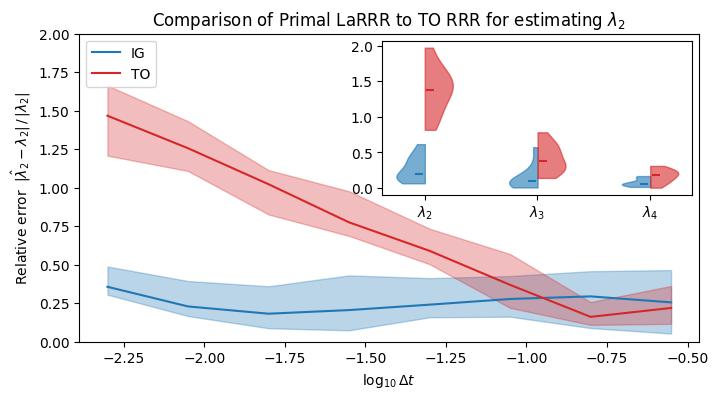

In [20]:
# Plotting
eval_idx = 0
dt_index = -1
dt_range = np.log10(0.5*(10**(-np.arange(9)/4))) #[0.005,0.01,0.05,0.1] #0.01, 0.005
 
plt.figure(figsize=(8, 4))

# Plot LaRRR with shading
plt.plot(dt_range[1:], LaRRR_err_median[1:,eval_idx], label='IG', color='tab:blue')
plt.fill_between(dt_range[1:], LaRRR_err_quantile_lower[1:,eval_idx], LaRRR_err_quantile_upper[1:,eval_idx], color='tab:blue', alpha=0.3)

# Plot LaRRR with shading
plt.plot(dt_range[1:], ToRRR_err_median[1:,eval_idx], label='TO', color='tab:red',)
plt.fill_between(dt_range[1:], ToRRR_err_quantile_lower[1:,eval_idx], ToRRR_err_quantile_upper[1:,eval_idx], color='tab:red', alpha=0.3)

# Add labels, title, and legend
#plt.xticks(ticks = dt_range, labels=[".005",".01", ".05", ".1" ][::-1])
#plt.xlim([0,0.1])
plt.xlabel('$\log_{10} \Delta t$')
plt.ylim([0,2])
plt.ylabel('Relative error $\;|\hat{\lambda}_2 - \lambda_2| \,/\,|\lambda_2|$')
plt.title('Comparison of Primal LaRRR to TO RRR for estimating $\lambda_'+str(eval_idx+2)+'$')
plt.legend(loc="upper left")

# Create inset axes for the violin plot
ax_inset = inset_axes(plt.gca(), width="50%", height="50%", loc='upper right')

# Style of violin plots
s_kwargs = {"s": 40, "marker": "_"}
v_kwargs = {"showextrema": False, "showmedians": False, "showmeans": False, "widths": 0.5}
labels = [r'$\lambda_2$', r'$\lambda_3$', r'$\lambda_4$']

for i in range(3):
    # Create violin plot for array 'IG'
    custom_violin(ax_inset, LaRRR_err[dt_index,:, i], i  , 'tab:blue', 'tab:blue', 0.6, percentiles=[50], side="left", scatter_kwargs=s_kwargs, violin_kwargs=v_kwargs)
    
    # Create violin plot for array 'TO'
    custom_violin(ax_inset, ToRRR_err[dt_index,:, i], i , 'tab:red', 'tab:red', 0.6, percentiles=[50], side = "right", scatter_kwargs=s_kwargs, violin_kwargs=v_kwargs)

#plt.legend(labels=["IG distribution","IG meadian","TO  distribution","TO meadian"])

ax_inset.set_xticks([i for i in range(3)])
ax_inset.set_xticklabels(labels)


# Show the plot
plt.show()